In [1]:
!pip install category_encoders
!pip install texthero
!pip install textdistance


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from gensim.models import word2vec

In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub13/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()

    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)

    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [5]:

def create_boolean_feature(input_df):
    output_df = pd.DataFrame()

    texts = [
        'japan', 'nintendo'
    ]

    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [6]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

In [7]:
_df = train_df.groupby('Name')['Platform'].count()
pd.merge(train_df['Name'], _df, on='Name', how='left').values[:, 1]

array([7, 4, 7, ..., 1, 2, 2], dtype=object)

In [8]:
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE_')

In [9]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column
        self.cats_ = None

    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > 40].index
        self.cats_ = cats
        return self.transform(input_df)

    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')

In [10]:
from textdistance import jaro


In [11]:
from nltk.util import ngrams

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

In [12]:
def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n

    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index

        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [13]:
block = NameNGramBlock(train_df, n=3)
block.fit(train_df).head()

,Name_has_major-league-baseball_n=3,Name_has_grand-theft-auto_n=3,Name_has_smackdown-vs-raw_n=3,Name_has_super-robot-taisen_n=3,Name_has_wwe-smackdown-vs_n=3,Name_has_shin-megami-tensei_n=3,Name_has_lego-star-wars_n=3,Name_has_dragon-ball-z_n=3,Name_has_katekyoo-hitman-reborn_n=3,Name_has_star-wars-force_n=3,Name_has_marvel-super-heroes_n=3,Name_has_romance-three-kingdoms_n=3,Name_has_hisshou-pachinko-pachi_n=3,Name_has_mx-vs-atv_n=3,Name_has_lego-harry-potter_n=3,Name_has_pachi-slot-kouryaku_n=3,Name_has_slot-kouryaku-series_n=3,Name_has_pachinko-pachi-slot_n=3,Name_has_rock-band-track_n=3,Name_has_harry-potter-years_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [14]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [15]:
key = 'Genre'

input_df = train_df
input_df[sales_columns].groupby(input_df[key]).sum()

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,30483,106343,10165,54010,11610
Adventure,4522,16634,3753,7229,1131
Fighting,5807,27258,5808,13313,2307
Misc,13411,48441,7803,22588,4601
Platform,16573,71149,12114,38119,4320
Puzzle,3871,19153,4497,9849,921
Racing,13039,44301,5026,21745,4465
Role-Playing,13536,72067,29886,24282,4348
Shooter,10890,43028,1964,26631,3506


In [16]:
key = 'Genre'

input_df = train_df

_df = input_df[sales_columns].groupby(input_df[key]).sum()
_df = (_df.T / _df.sum(axis=1)).T
_df

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,0.143375,0.500176,0.047810,0.254032,0.054607
Adventure,0.135922,0.499985,0.112808,0.217289,0.033996
Fighting,0.106564,0.500211,0.106582,0.244307,0.042336
Misc,0.138480,0.500196,0.080573,0.233241,0.047509
Platform,0.116486,0.500081,0.085145,0.267925,0.030364
Puzzle,0.101094,0.500196,0.117443,0.257214,0.024053
Racing,0.147207,0.500147,0.056742,0.245495,0.050409
Role-Playing,0.093922,0.500052,0.207370,0.168486,0.030170
Shooter,0.126600,0.500215,0.022832,0.309594,0.040758


In [17]:
class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""

    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None

    def fit(self, input_df):
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [18]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)

In [19]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [20]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    NameNGramBlock(whole_df, n=3),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Publisher', 'Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Year_of_Release']],
    *[SalesPortfolioBlock(c) for c in ['Genre']]
]

In [21]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df


In [22]:
train_feat_df = to_feature(train_df, process_blocks, is_train=True)
test_feat_df = to_feature(test_df, process_blocks)

  0%|          | 0/11 [00:00<?, ?it/s]

create <__main__.WrapperBlock object at 0x7fa7ee7ae748> 0.007[s]
create <__main__.WrapperBlock object at 0x7fa7ee7ae828> 0.011[s]


  0%|          | 0/11 [00:00<?, ?it/s]

create <__main__.NameNGramBlock object at 0x7fa7ee7ae898> 0.303[s]
create <__main__.OneHotBlock object at 0x7fa7ee7ae860> 0.003[s]
create <__main__.OneHotBlock object at 0x7fa7ee7aef98> 0.002[s]
create <__main__.OneHotBlock object at 0x7fa7ee7aef60> 0.003[s]
create <__main__.OneHotBlock object at 0x7fa7ee7aeac8> 0.002[s]
create <__main__.CountEncodingBlock object at 0x7fa7ee7aeef0> 0.005[s]
create <__main__.CountEncodingBlock object at 0x7fa7ee7ae8d0> 0.003[s]
create <__main__.CountEncodingBlock object at 0x7fa7ee7ae978> 0.002[s]
create <__main__.SalesPortfolioBlock object at 0x7fa7ee7ae9b0> 0.005[s]
create <__main__.WrapperBlock object at 0x7fa7ee7ae748> 0.003[s]
create <__main__.WrapperBlock object at 0x7fa7ee7ae828> 0.011[s]


100%|██████████| 11/11 [00:00<00:00, 46.32it/s]

create <__main__.NameNGramBlock object at 0x7fa7ee7ae898> 0.196[s]
create <__main__.OneHotBlock object at 0x7fa7ee7ae860> 0.001[s]
create <__main__.OneHotBlock object at 0x7fa7ee7aef98> 0.001[s]
create <__main__.OneHotBlock object at 0x7fa7ee7aef60> 0.001[s]
create <__main__.OneHotBlock object at 0x7fa7ee7aeac8> 0.001[s]
create <__main__.CountEncodingBlock object at 0x7fa7ee7aeef0> 0.005[s]
create <__main__.CountEncodingBlock object at 0x7fa7ee7ae8d0> 0.003[s]
create <__main__.CountEncodingBlock object at 0x7fa7ee7ae978> 0.002[s]
create <__main__.SalesPortfolioBlock object at 0x7fa7ee7ae9b0> 0.002[s]


In [23]:
train_feat_df.columns

Index(['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count',
       'Year_of_Release', 'User_Score_is_tbd', 'Developer_has_japan',
       'Developer_has_nintendo', 'Name_has_jikkyou-powerful-pro_n=3',
       'Name_has_pro-evolution-soccer_n=3',
       ...
       'OH_Rating=M', 'OH_Rating=E10+', 'CE_Name', 'CE_Platform',
       'CE_Year_of_Release', 'SP@Genre_EU_Sales', 'SP@Genre_Global_Sales',
       'SP@Genre_JP_Sales', 'SP@Genre_NA_Sales', 'SP@Genre_Other_Sales'],
      dtype='object', length=106)

In [24]:
X = train_feat_df.astype('float64')
y = train_df['Global_Sales'].astype('float64')
test_df = test_feat_df

In [29]:
train_column = train_df.columns

In [30]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [31]:
train_df_drop = train_df[X_column]

In [32]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [33]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [34]:
# Ratingの変換

In [35]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [36]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: "None of [Index(['Rating', 'Platform', 'Genre'], dtype='object')] are in the [columns]"

In [37]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [73]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    pca = PCA(n_components=2)
    w_vec_pca = pca.fit_transform(w_vec)
    
    df['Name_0'] = w_vec_pca[:, 0]
    df['Name_1'] = w_vec_pca[:, 1]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [74]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



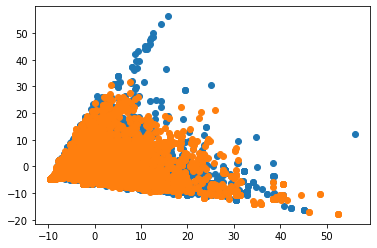

In [75]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

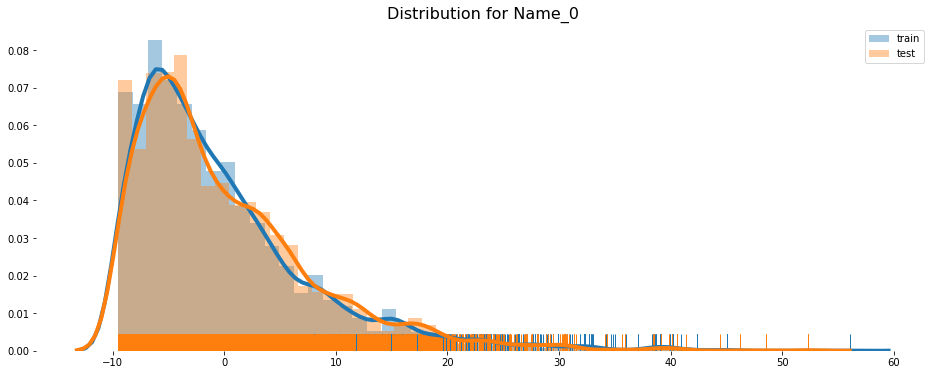

In [76]:
cols = 'Name_0'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Name_0'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Name_0'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

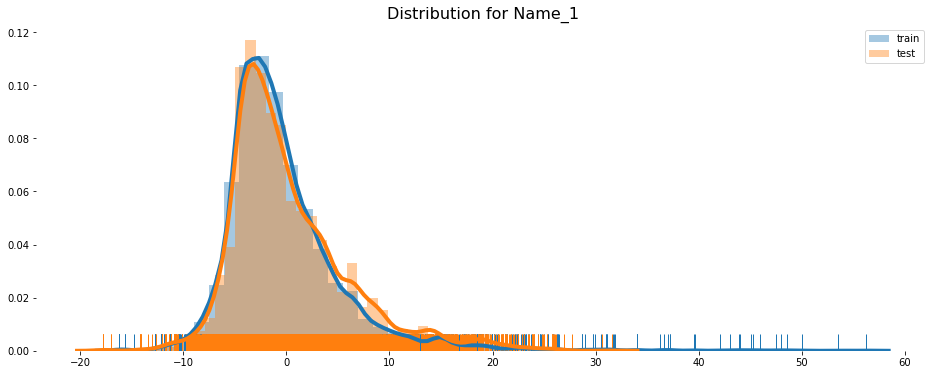

In [77]:
cols = 'Name_1'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Name_1'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Name_1'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

In [78]:
def translate_developer(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Publisher'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    pca = PCA(n_components=2)
    w_vec_pca = pca.fit_transform(w_vec)
    
    df['Developer_0'] = w_vec_pca[:, 0]
    df['Developer_1'] = w_vec_pca[:, 1]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [45]:
train_df_drop, test_df = translate_developer(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



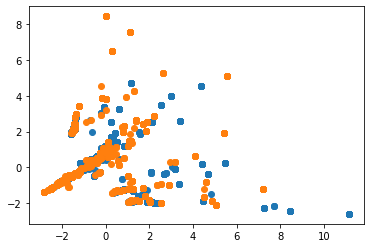

In [46]:
plt.scatter(train_df_drop['Developer_0'].values, train_df_drop['Developer_1'].values)
plt.scatter(test_df['Developer_0'].values, test_df['Developer_1'].values)

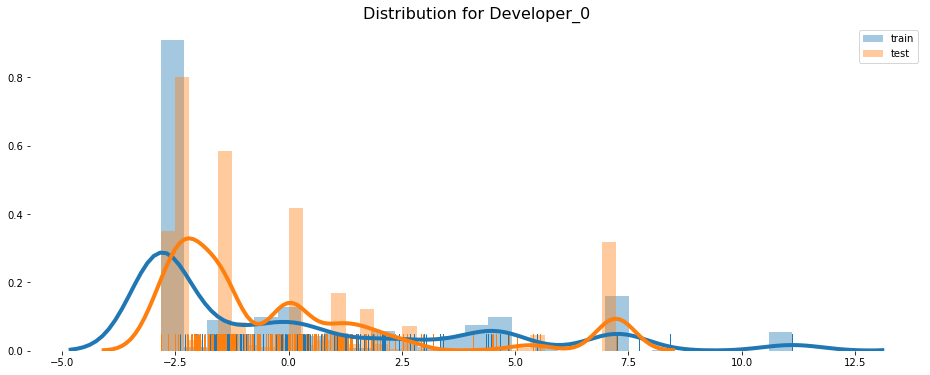

In [47]:
cols = 'Developer_0'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Developer_0'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Developer_0'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

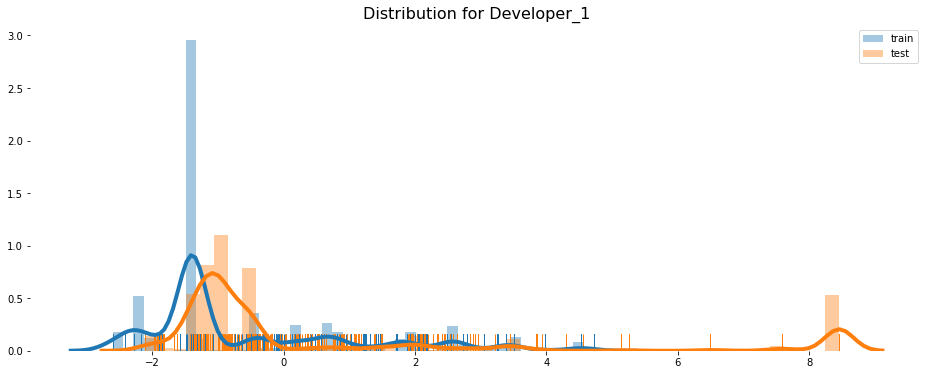

In [48]:
cols = 'Developer_1'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Developer_1'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Developer_1'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

In [79]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Name_0,Name_1
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,12.449312,-7.095173
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,20.005083,-7.109552
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,12.449312,-7.095173
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-6.980628,-3.526879
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,15.165423,-5.791763
...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,-9.489566,-4.711438
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,2.535284,-4.089223
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,-3.639430,-1.776631
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,7.182669,1.728667


In [80]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [81]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [26]:
from sklearn import model_selection
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [30]:


# kfoldの分割数
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
              "learning_rate": 0.05,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.760522	valid_0's rmse: 0.899636
[400]	training's rmse: 0.690834	valid_0's rmse: 0.890451
[600]	training's rmse: 0.64566	valid_0's rmse: 0.889077
[800]	training's rmse: 0.610906	valid_0's rmse: 0.889733
[1000]	training's rmse: 0.583021	valid_0's rmse: 0.892988
[1200]	training's rmse: 0.561712	valid_0's rmse: 0.896776
[1400]	training's rmse: 0.543045	valid_0's rmse: 0.900567
Early stopping, best iteration is:
[550]	training's rmse: 0.655942	valid_0's rmse: 0.887869
RMSLE_train: 0.6559418288319763, RMSLE_eval: 0.8878687378530427
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.770051	valid_0's rmse: 0.819603
[400]	training's rmse: 0.698896	valid_0's rmse: 0.81567
[600]	training's rmse: 0.654441	valid_0's rmse: 0.815891
[800]	training's rmse: 0.620849	valid_0's rmse: 0.81552
[1000]	training's rmse: 0.59423	valid_0's rmse: 0.817698
[1200]	training's rmse: 0.571809	v

In [31]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.8716292006078639


In [33]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof13.csv", index = False)

In [34]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [35]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub13.csv", index = False)

In [87]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

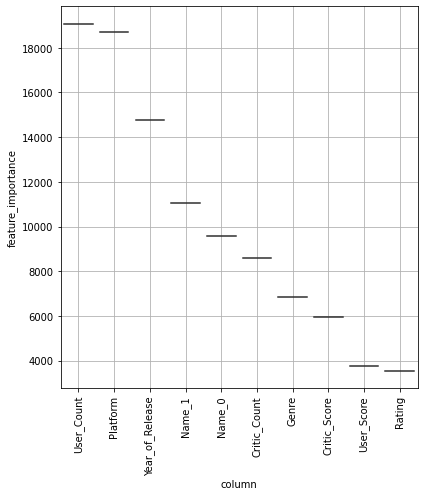

In [88]:
fig, ax = visualize_importance(model, X)


In [89]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Rating,3541.424763
User_Score,3762.594382
Critic_Score,5945.821293
Genre,6855.950514
Critic_Count,8590.046331
Name_0,9584.047110
Name_1,11068.488889
Year_of_Release,14787.648650
Platform,18717.573786
User_Count,19073.707179


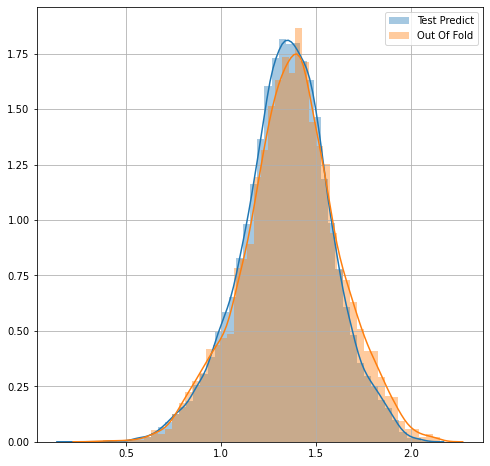

In [90]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

In [41]:
for c in train_feat_df.columns:
    if 'Publish' in c:
        print(c)

OH_Publisher=THQ
OH_Publisher=Nintendo
OH_Publisher=Sony Computer Entertainment
OH_Publisher=Sega
OH_Publisher=Take-Two Interactive
OH_Publisher=Capcom
OH_Publisher=Atari
OH_Publisher=Tecmo Koei
OH_Publisher=Warner Bros. Interactive Entertainment
OH_Publisher=Square Enix
OH_Publisher=Disney Interactive Studios
OH_Publisher=505 Games
OH_Publisher=Microsoft Game Studios
OH_Publisher=D3Publisher
OH_Publisher=Vivendi Games
OH_Publisher=Idea Factory
OH_Publisher=Nippon Ichi Software
OH_Publisher=Majesco Entertainment
OH_Publisher=LucasArts
OH_Publisher=Bethesda Softworks
OH_Publisher=Banpresto
OH_Publisher=Crave Entertainment
OH_Publisher=Atlus
OH_Publisher=Focus Home Interactive
OH_Publisher=Ignition Entertainment
OH_Publisher=Marvelous Interactive
OH_Publisher=SquareSoft
OH_Publisher=Kadokawa Shoten
OH_Publisher=Destineer
OH_Publisher=Alchemist
OH_Publisher=MTV Games


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



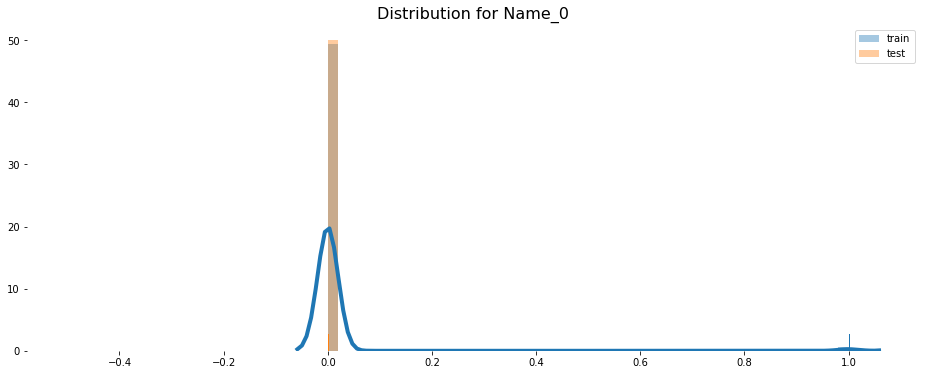

In [46]:
cols = 'Name_0'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_feat_df['OH_Publisher=Nippon Ichi Software'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['OH_Publisher=Nippon Ichi Software'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()